<a href="https://colab.research.google.com/github/clphan/k8s-resource-recommendations-system/blob/master/thesis_BI_LSTM_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trong mô hình LSTM, đầu tiên chúng ta sẽ load dữ liệu lên với dạng Pandas dataframe, tiền xử lý dữ liệu bằng cách chuẩn hóa tập dữ liệu đầu vào "event_count" sử dụng MinMaxScaler, sau đó thực hiện việc chia tập dữ liệu thành tập training sets và tập test sets. Ta định nghĩa mô hình LSTM với 2 lớp (2 layers), comples model sử dụng Adam optimizer và mean squared error để tính toán loss function. Qúa trình train model sử dụng tập dữ liệu training và tương ứng việc đánh giá tập dữ liệu sẽ sử dụng tập dữ liệu test. Hình dạng (shape) của tập dữ liệu cần phải được reshaped để phù hợp với tập dữ liệu input của một mô hình LSTM.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import matplotlib.pyplot as plt
from joblib import dump, load
from pandas.plotting import lag_plot, autocorrelation_plot
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
# Load the data into a Pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/thesis/processed-data/wc_dataset_processed.csv') #, usecols=[1, 2, 3])
# df.head(), df.shape
df.head(10)

,event_time,event_count,sum_bytes,num_match_event
0,1998-04-30 21:30:00,1,24736,0
1,1998-04-30 21:31:00,11,83086,0
2,1998-04-30 21:32:00,16,87949,0
3,1998-04-30 21:33:00,7,149401,0
4,1998-04-30 21:34:00,3,50457,0
5,1998-04-30 21:35:00,2,49472,0
6,1998-04-30 21:36:00,3,74208,0
7,1998-04-30 21:37:00,4,98944,0
8,1998-04-30 21:38:00,5,99929,0
9,1998-04-30 21:39:00,9,174327,0


Plot dữ liệu liên quan đến số request theo đơn vị thời gian và số lượng bytes mà hệ thống trả về theo đơn vị thời gian

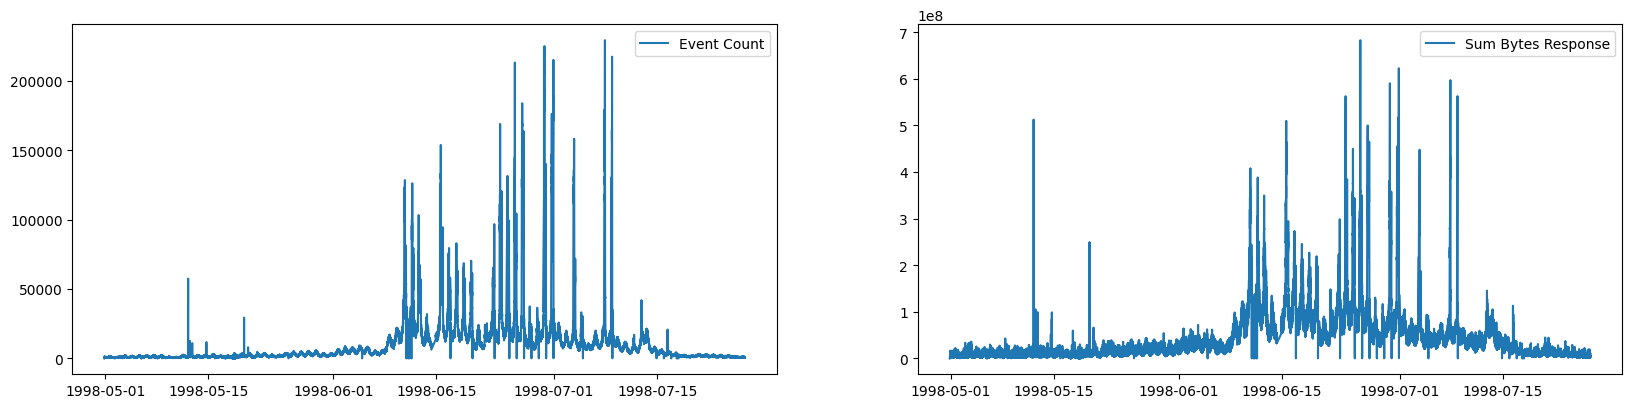

In [ ]:
df_plot_noise = df
df_plot_noise['event_time'] = pd.to_datetime(df_plot_noise['event_time'])
# Show the plot event_count
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(2, 2, 1)  # Top left
ax2 = fig.add_subplot(2, 2, 2)  # Top right

ax1.plot(color='red', marker='o', markerfacecolor='blue')
ax1.plot(df_plot_noise['event_time'], df_plot_noise['event_count'], label='Event Count')#, color='blue')
# ax1.set_title('Event Count vs Time')
ax1.legend()
# Show the plot num_bytes_response
ax2.plot(color='red', marker='o', markerfacecolor='orange')
ax2.plot(df_plot_noise['event_time'], df_plot_noise['sum_bytes'], label='Sum Bytes Response')#,  color='green')
# ax2.set_title('Sum Bytes Response vs Time')
ax2.legend()

plt.show()

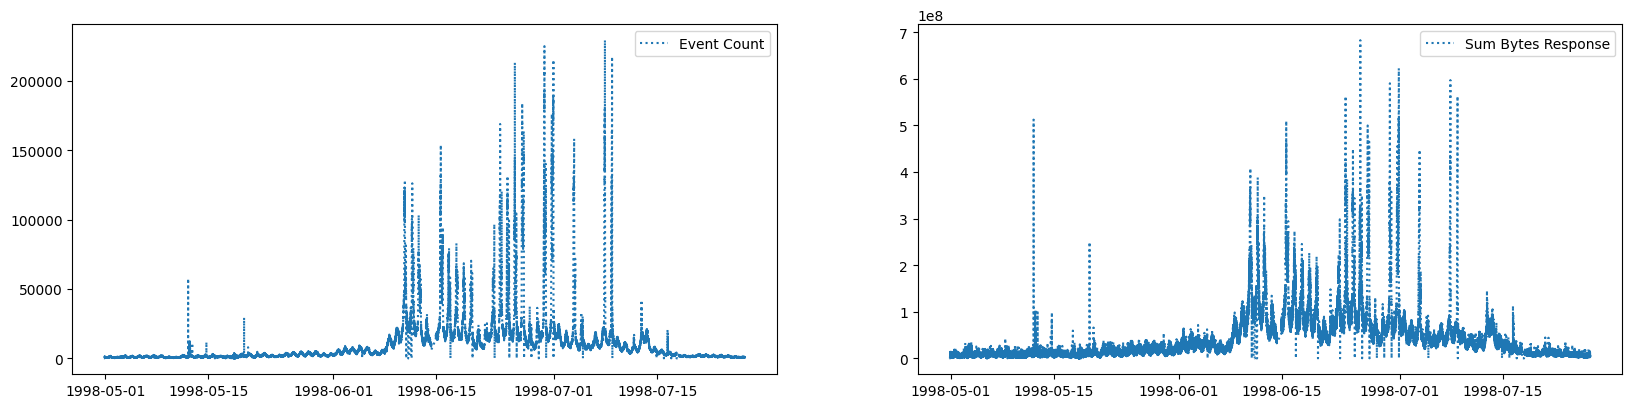

In [ ]:
df_plot_noise = df
df_plot_noise['event_time'] = pd.to_datetime(df_plot_noise['event_time'])
# Show the plot event_count
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(2, 2, 1)  # Top left
ax2 = fig.add_subplot(2, 2, 2)  # Top right

ax1.plot(color='red', marker='o', markerfacecolor='blue')
ax1.plot(df_plot_noise['event_time'], df_plot_noise['event_count'], label='Event Count', linestyle='dotted')#, color='blue')
# ax1.set_title('Event Count vs Time')
ax1.legend()
# Show the plot num_bytes_response
ax2.plot(color='red', marker='o', markerfacecolor='orange')
ax2.plot(df_plot_noise['event_time'], df_plot_noise['sum_bytes'], label='Sum Bytes Response', linestyle='dotted')#,  color='green')
# ax2.set_title('Sum Bytes Response vs Time')
ax2.legend()

plt.show()

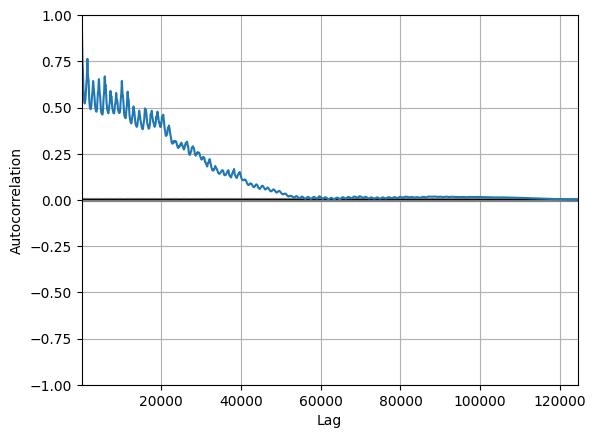

In [ ]:
autocorrelation_plot(df)
plt.show()

**Correlation analysis:** Correlation analysis involves quantifying the relationship between pairs of variables in the dataset. This can be useful for identifying strong correlations between variables that may need to be accounted for in the LSTM model. Correlation analysis can be performed using techniques such as Pearson correlation, Spearman correlation, and Kendall correlation.

<Axes: >

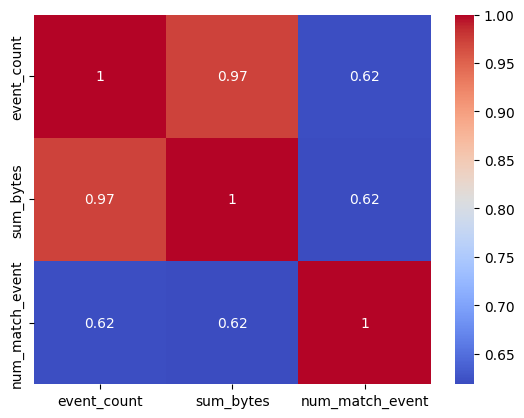

In [ ]:
# Analisys dataset
corr_matrix = df.corr()
# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

**Exploratory data analysis (EDA):** EDA involves visualizing and summarizing the key features of the dataset to gain insights into the relationships between the variables. This can involve techniques such as scatterplots, histograms, and boxplots, among others. EDA can help to identify outliers, missing values, and other issues in the data that may need to be addressed before applying an LSTM model.

In [ ]:
# Display the first few rows of the DataFrame
print(df.head())
# Check the data types of each column
print(df.dtypes)
# Check for missing values
print(df.isnull().sum())
# Compute summary statistics for numerical columns
print(df.describe())

   event_count  sum_bytes  num_match_event
0            1      24736                0
1           11      83086                0
2           16      87949                0
3            7     149401                0
4            3      50457                0
event_count        int64
sum_bytes          int64
num_match_event    int64
dtype: object
event_count        0
sum_bytes          0
num_match_event    0
dtype: int64
         event_count     sum_bytes  num_match_event
count  124464.000000  1.244640e+05    124464.000000
mean    10668.624920  4.226053e+07      1186.045764
std     19294.044487  5.774806e+07      5341.939669
min         0.000000  0.000000e+00         0.000000
25%      1436.000000  8.875887e+06         0.000000
50%      3754.500000  2.160449e+07         0.000000
75%     13460.000000  5.608888e+07         0.000000
max    229426.000000  6.831307e+08     40000.000000


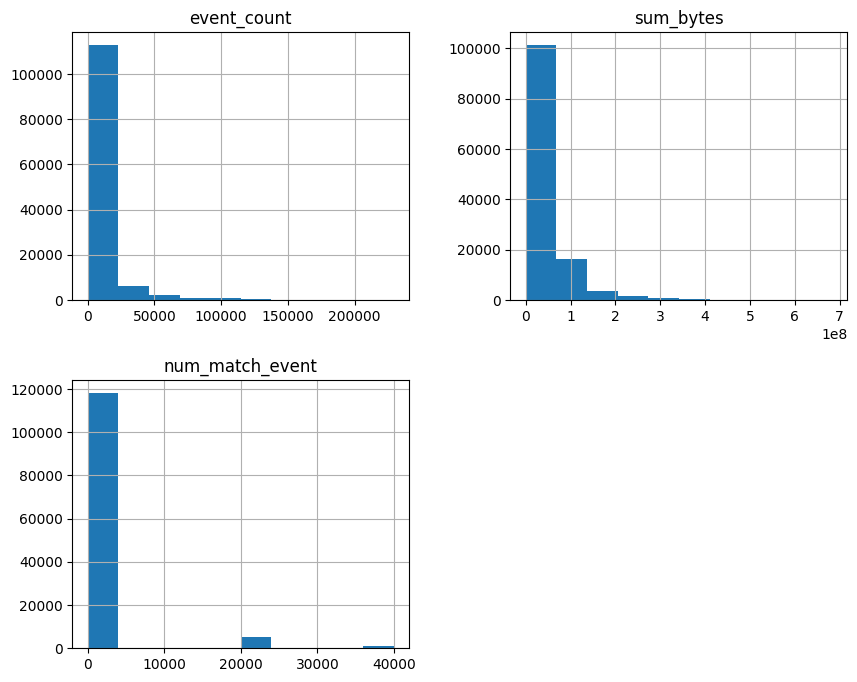

In [ ]:
# Plot a histogram of each numerical column
df.hist(bins=10, figsize=(10,8))
plt.show()

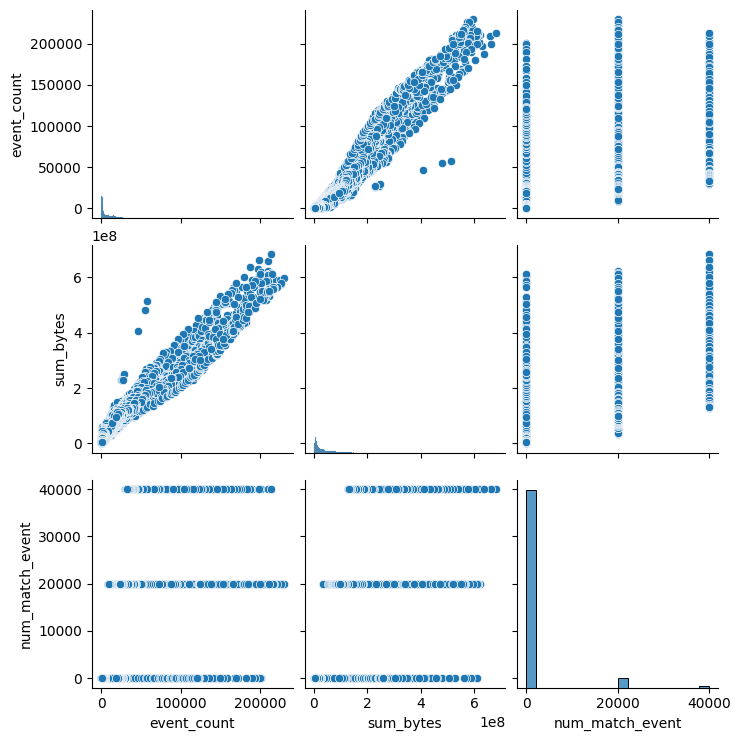

In [ ]:
# Plot a scatterplot matrix of the numerical columns
sns.pairplot(df, diag_kind='hist')
plt.show()

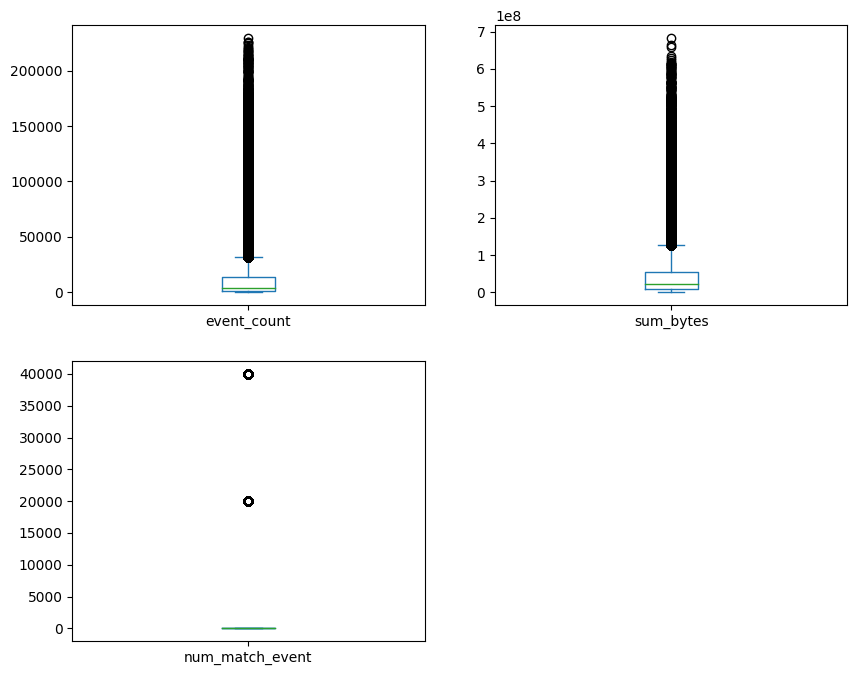

In [ ]:
# Create a boxplot of each numerical column
df.plot(kind='box', subplots=True, layout=(2,2), figsize=(10,8))
plt.show()

**Cluster analysis:** Cluster analysis involves grouping the data points into clusters based on their similarity. This can be useful for identifying patterns and trends in the data and for identifying groups of similar data points that may require different modeling approaches. Cluster analysis can be performed using techniques such as k-means clustering, hierarchical clustering, and density-based clustering.

In this code, we first load the dataset into a Pandas DataFrame. Then we standardize the dataset using the StandardScaler class. Next, we determine the number of clusters using the elbow method and plot the within-cluster sum of squares against the number of clusters. Based on the plot, we choose the number of clusters as 3. Then we run the KMeans algorithm with 3 clusters and assign the data points to their respective clusters. Finally, we visualize the clusters by plotting the data points with different colors based on their assigned clusters.

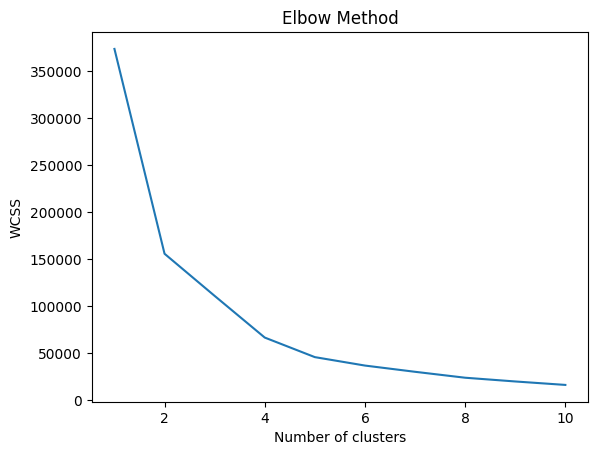

In [ ]:
# Data preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(df.values)
# Determine the number of clusters using the elbow method
wcss = [] # Within-Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

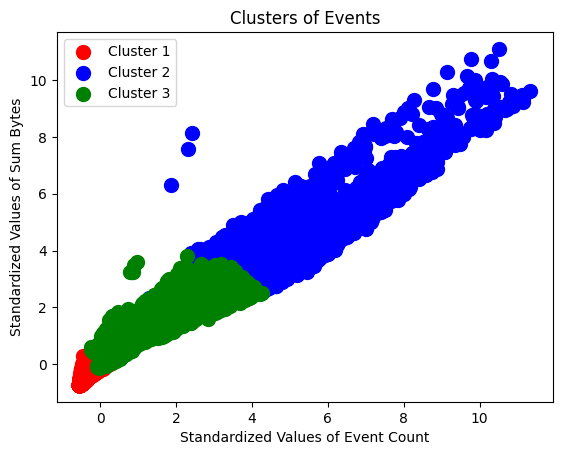

In [ ]:
# Run clustering algorithm
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X)
# Visualize clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.title('Clusters of Events')
plt.xlabel('Standardized Values of Event Count')
plt.ylabel('Standardized Values of Sum Bytes')
plt.legend()
plt.show()

<Axes: >

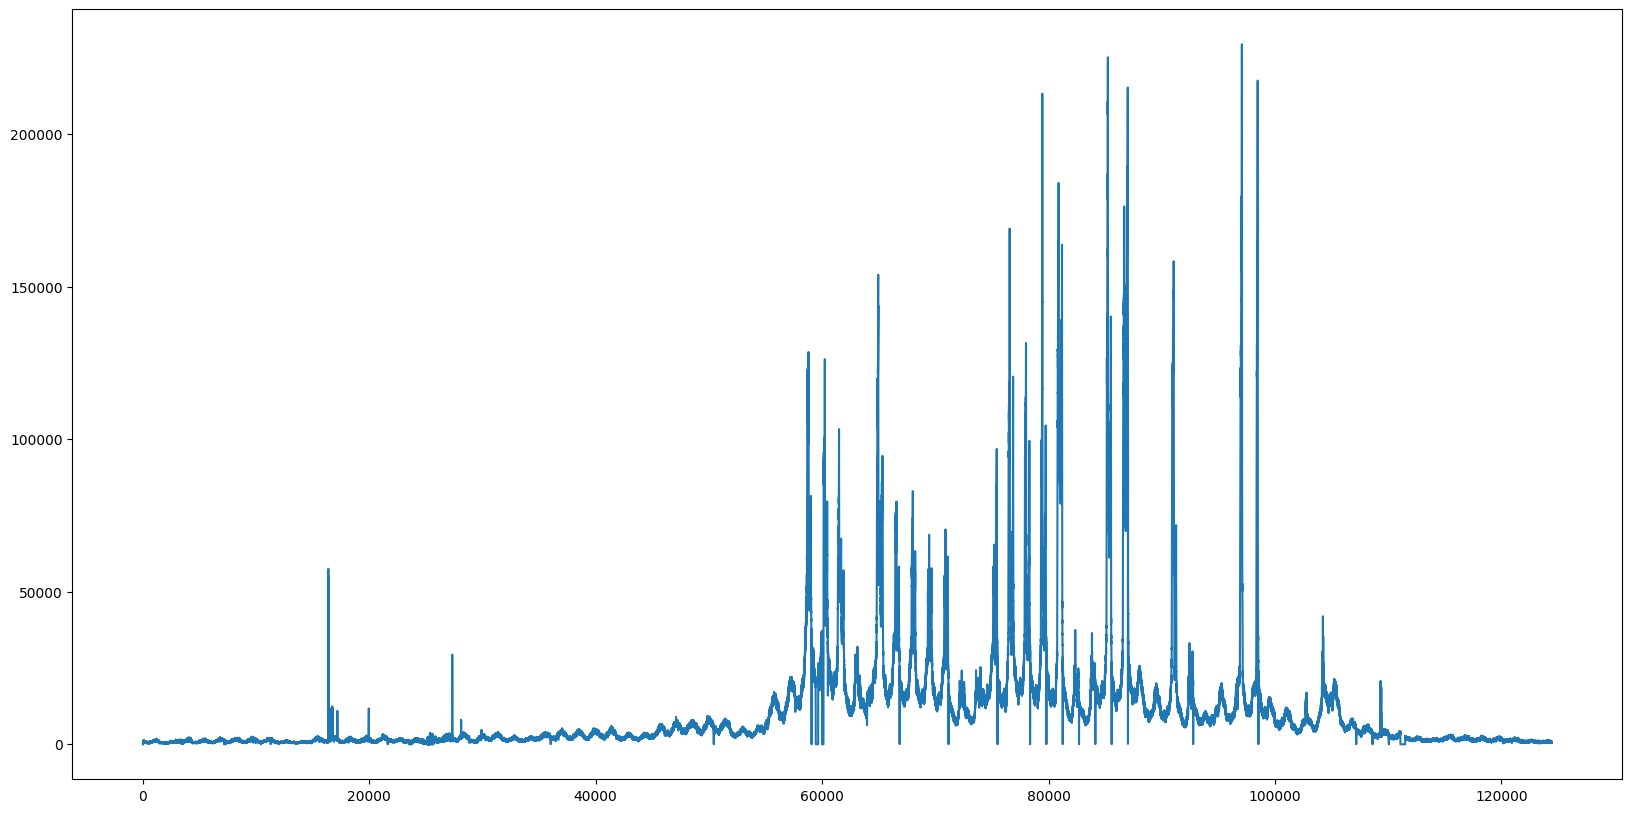

In [ ]:
df['event_count'].plot(figsize=(20,10))

<Axes: >

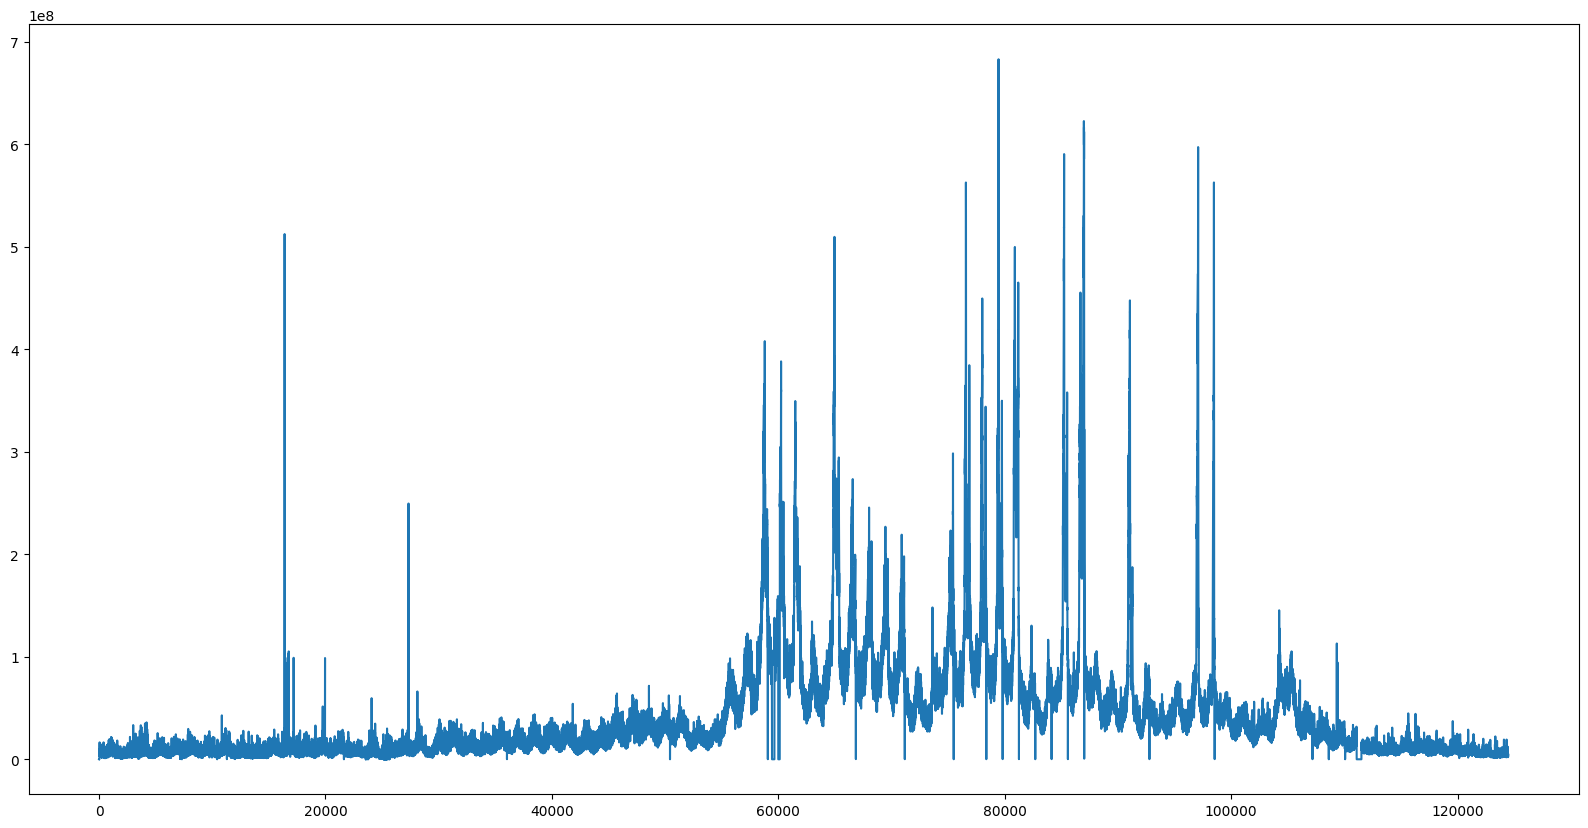

In [ ]:
df['sum_bytes'].plot(figsize=(20,10))

In [ ]:
## Preprocess data to remove noise
df['noise_label'] = 0
for i in range(len(df)):
    if i < 35000:
        continue
    # get the current value of event_count
    current_count = df.loc[i, 'event_count']
    # get the past and future values of event_count
    past_past_count = df.loc[i-2, 'event_count'] if i > 0 else current_count
    past_count = df.loc[i-1, 'event_count'] if i > 0 else current_count
    future_count = df.loc[i+1, 'event_count'] if i < len(df)-1 else current_count
    delta_past_past = past_count - past_past_count
    delta_past = current_count - past_count
    delta_future = future_count - current_count

    if delta_past_past < 0 and delta_past < 0 and 100*abs(delta_past / (delta_past_past + delta_past)) >= 30 and current_count < 150:
        df.loc[i, 'noise_label'] = 250000
        continue
    if delta_past_past > 0 and delta_past < 0 and 100*abs(delta_past / (delta_past_past - delta_past)) >= 80 and current_count < 150:
        df.loc[i, 'noise_label'] = 250000
        continue
    # check if the condition is met
    if delta_future == 0 and delta_past == 0 and current_count < 100:
        df.loc[i, 'noise_label'] = 250000
        continue
    if delta_future < 0 and delta_past < 0 and future_count ==0:
        df.loc[i, 'noise_label'] = 250000
        continue
    if delta_future > 5000 and delta_past < 1000 and current_count < 100:
        df.loc[i, 'noise_label'] = 250000
        continue
    if delta_future > 1000 and delta_past == 0 and current_count == 0:
        df.loc[i, 'noise_label'] = 250000
        continue
    if current_count == 0 and i > 5000 and i < 100000:
        df.loc[i, 'noise_label'] = 250000
        continue
    if i > 59750 and i < 60250 and current_count < 1500:
        df.loc[i, 'noise_label'] = 250000
        continue
    if 100*delta_future / (delta_past + delta_future) >= 80 and future_count <= current_count and current_count < 150:
        # print(past_count, current_count, future_count, True)
        df.loc[i, 'noise_label'] = 250000
        continue

<ipython-input-25-d690b19e2655>:41: RuntimeWarning: divide by zero encountered in long_scalars
  if 100*delta_future / (delta_past + delta_future) >= 80 and future_count <= current_count and current_count < 150:
<ipython-input-25-d690b19e2655>:41: RuntimeWarning: invalid value encountered in long_scalars
  if 100*delta_future / (delta_past + delta_future) >= 80 and future_count <= current_count and current_count < 150:


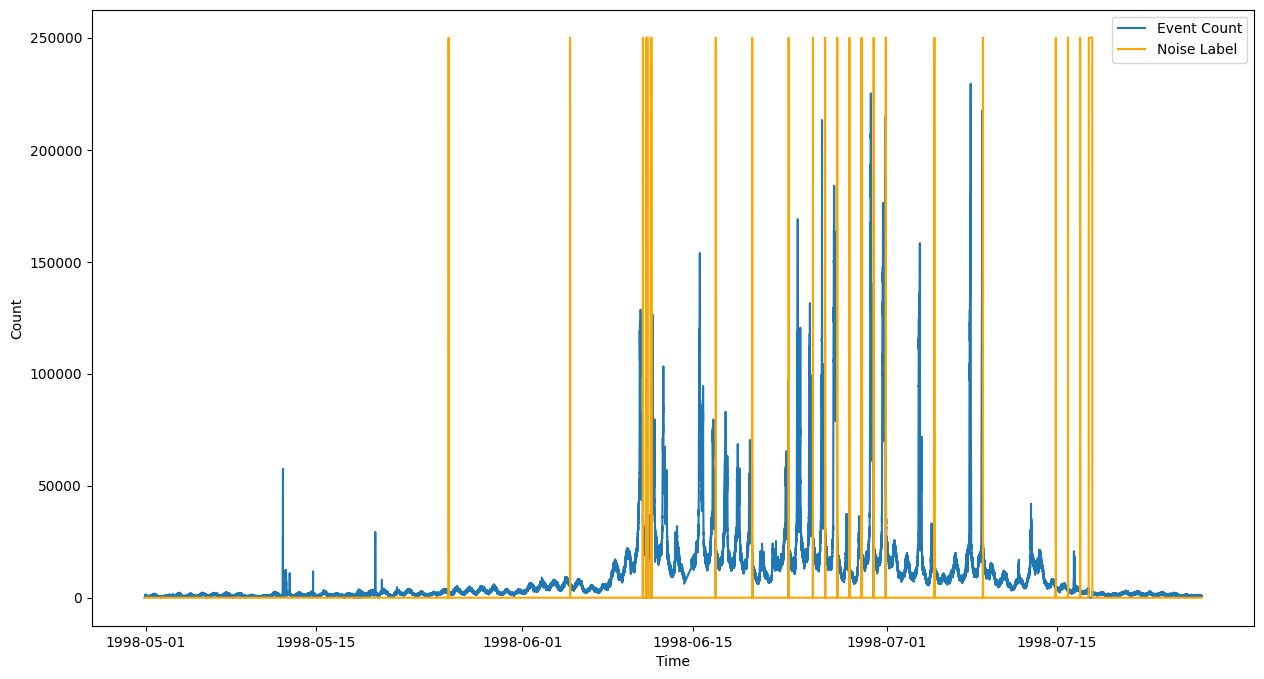

In [ ]:
df_plot_detect_noise = df
# Define the start and end times for the plot
df_plot_detect_noise['event_time'] = pd.to_datetime(df_plot_detect_noise['event_time'])
# Show the plot
plt.figure(figsize=(15, 8))
# Create the plot for both variables
plt.plot(df_plot_detect_noise['event_time'], df_plot_detect_noise['event_count'], label='Event Count')
plt.plot(df_plot_detect_noise['event_time'], df_plot_detect_noise['noise_label'], label='Noise Label',  color='orange')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.show()

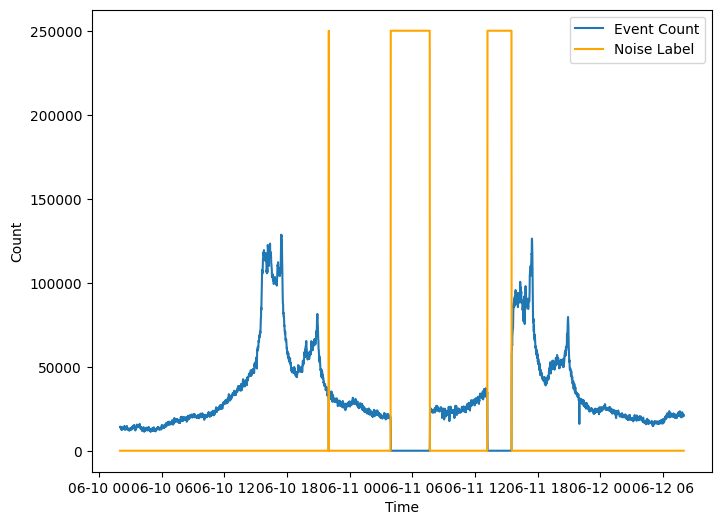

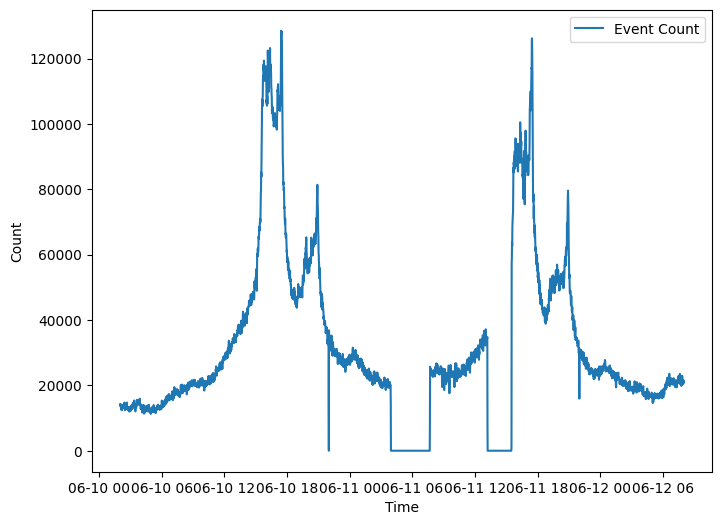

In [ ]:
# Define the start and end times for the plot
df_plot_detect_noise['event_time'] = pd.to_datetime(df_plot_detect_noise['event_time'])
start_time = pd.to_datetime('1998-06-10 02:00:00')
end_time = pd.to_datetime('1998-06-12 8:00:00')
# Filter the data between the start and end times
df_filtered = df_plot_detect_noise.loc[(df_plot_detect_noise['event_time'] >= start_time) & (df_plot_detect_noise['event_time'] <= end_time)]
# Show the plot
plt.figure(figsize=(8, 6))
# Create the plot for both variables
plt.plot(df_filtered['event_time'], df_filtered['event_count'], label='Event Count')
plt.plot(df_filtered['event_time'], df_filtered['noise_label'], label='Noise Label',  color='orange')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.show()
# Define the start and end times for the plot
df_plot_detect_noise['event_time'] = pd.to_datetime(df_plot_detect_noise['event_time'])
start_time = pd.to_datetime('1998-06-10 02:00:00')
end_time = pd.to_datetime('1998-06-12 8:00:00')
# Filter the data between the start and end times
df_filtered = df_plot_detect_noise.loc[(df_plot_detect_noise['event_time'] >= start_time) & (df_plot_detect_noise['event_time'] <= end_time)]
# Show the plot
plt.figure(figsize=(8, 6))
# Create the plot for both variables
plt.plot(df_filtered['event_time'], df_filtered['event_count'], label='Event Count')
# plt.plot(df_filtered['event_time'], df_filtered['noise_label'], label='Noise Label',  color='orange')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.show()

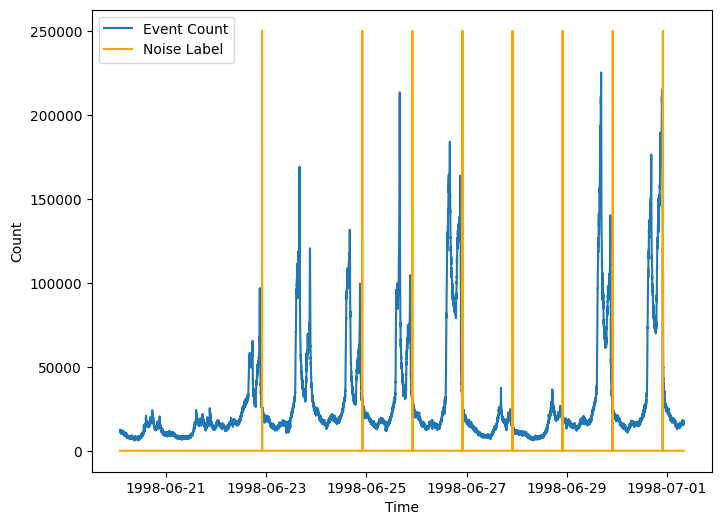

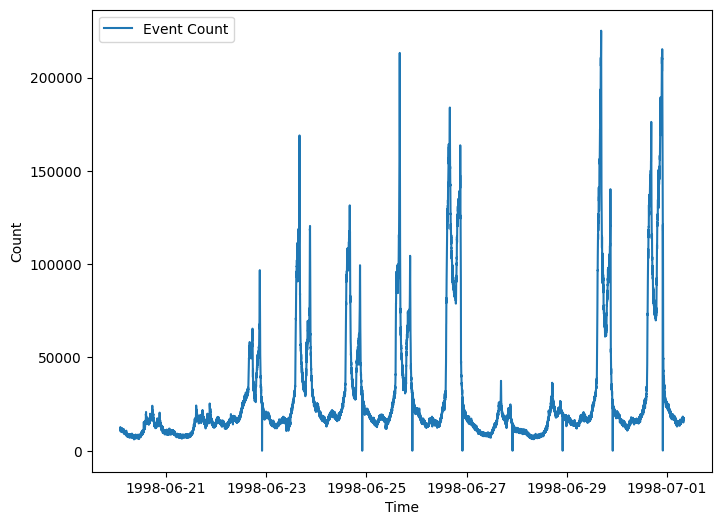

In [ ]:
# Define the start and end times for the plot
df_plot_detect_noise['event_time'] = pd.to_datetime(df_plot_detect_noise['event_time'])
start_time = pd.to_datetime('1998-06-20 02:00:00')
end_time = pd.to_datetime('1998-07-01 8:00:00')
# Filter the data between the start and end times
df_filtered = df_plot_detect_noise.loc[(df_plot_detect_noise['event_time'] >= start_time) & (df_plot_detect_noise['event_time'] <= end_time)]
# Show the plot
plt.figure(figsize=(8, 6))
# Create the plot for both variables
plt.plot(df_filtered['event_time'], df_filtered['event_count'], label='Event Count')
plt.plot(df_filtered['event_time'], df_filtered['noise_label'], label='Noise Label',  color='orange')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.show()
# Define the start and end times for the plot
df_plot_detect_noise['event_time'] = pd.to_datetime(df_plot_detect_noise['event_time'])
start_time = pd.to_datetime('1998-06-20 02:00:00')
end_time = pd.to_datetime('1998-07-01 8:00:00')
# Filter the data between the start and end times
df_filtered = df_plot_detect_noise.loc[(df_plot_detect_noise['event_time'] >= start_time) & (df_plot_detect_noise['event_time'] <= end_time)]
# Show the plot
plt.figure(figsize=(8, 6))
# Create the plot for both variables
plt.plot(df_filtered['event_time'], df_filtered['event_count'], label='Event Count')
# plt.plot(df_filtered['event_time'], df_filtered['noise_label'], label='Noise Label',  color='orange')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.show()

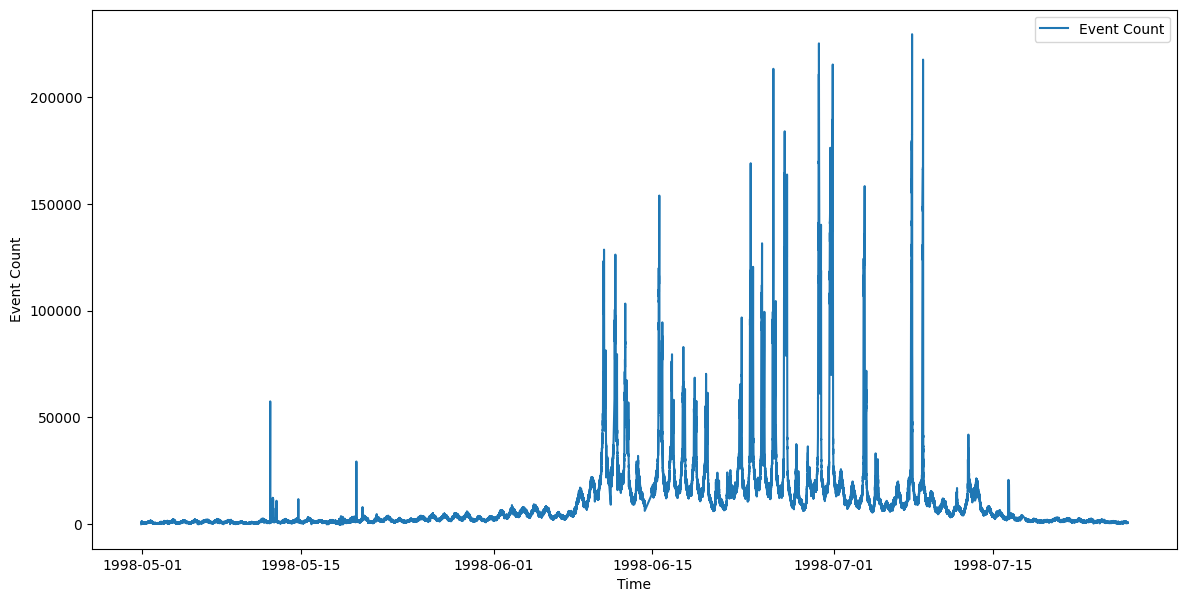

In [ ]:
df_noise_removed = df[df['noise_label'] != 250000]
# df_noise_removed['event_count'].plot(figsize=(20,10))
# Create the plot for both variables
plt.figure(figsize=(14, 7))
plt.plot(df_noise_removed['event_time'], df_noise_removed['event_count'], label='Event Count')
plt.xlabel('Time')
plt.ylabel('Event Count')
plt.legend()

plt.show()

In [ ]:
# df_noise_removed.to_csv('/content/drive/MyDrive/thesis/processed-data/wc_dataset_processed_noise_removed.csv')
df_wc_dataset_processed_noise_removed = df_noise_removed.drop('noise_label', axis=1)
df_wc_dataset_processed_noise_removed.head()
df_wc_dataset_processed_noise_removed.to_csv('/content/drive/MyDrive/thesis/processed-data/wc_dataset_processed_noise_removed.csv', index=False)

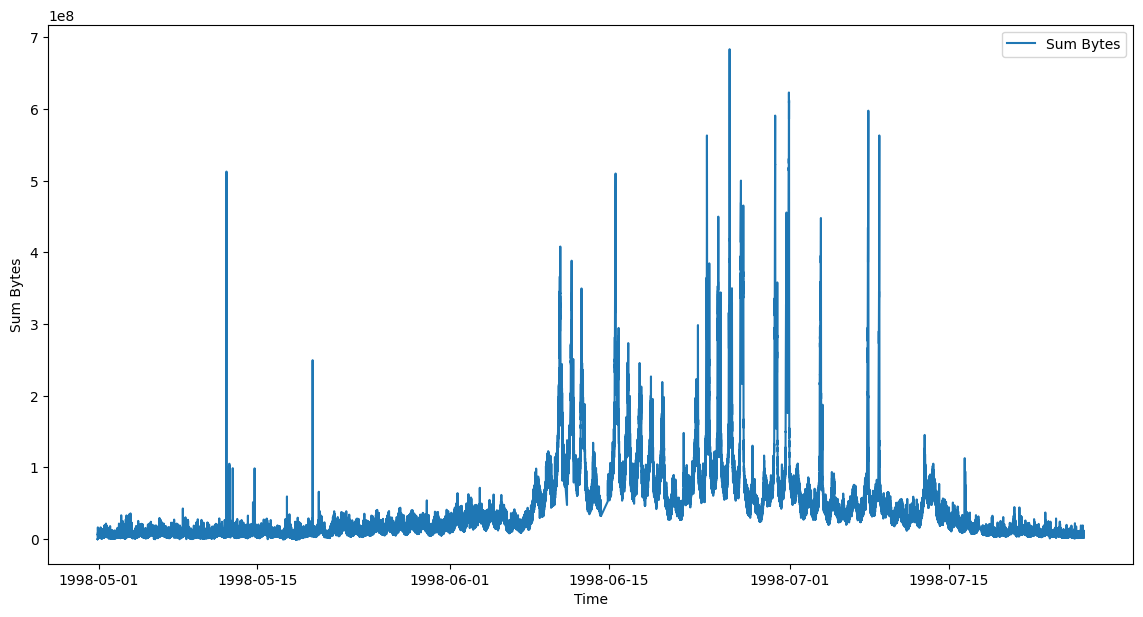

In [ ]:
df_noise_removed = df[df['noise_label'] != 250000]
# Create the plot for both variables
plt.figure(figsize=(14, 7))
plt.plot(df_noise_removed['event_time'], df_noise_removed['sum_bytes'], label='Sum Bytes')
plt.xlabel('Time')
plt.ylabel('Sum Bytes')
plt.legend()

plt.show()

**Phân tích lại dữ liệu sau khi đã loại bỏ nhiễu**

<ipython-input-72-ee5c34e4ec26>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_noise_removed['event_time'] = pd.to_datetime(df_plot_noise_removed['event_time'])


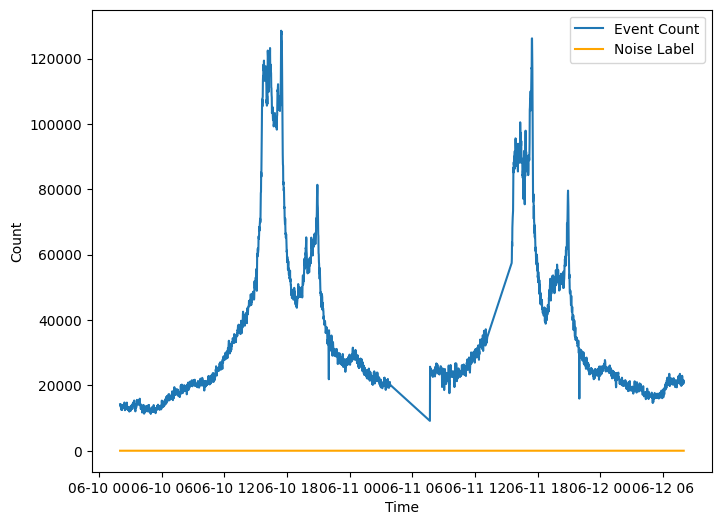

<ipython-input-72-ee5c34e4ec26>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_noise_removed['event_time'] = pd.to_datetime(df_plot_noise_removed['event_time'])


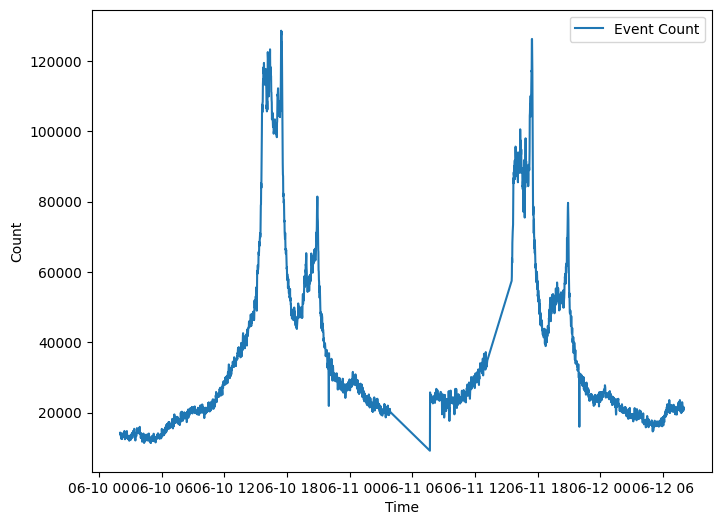

In [ ]:
# Define the start and end times for the plot
df_plot_noise_removed = df_noise_removed
df_plot_noise_removed['event_time'] = pd.to_datetime(df_plot_noise_removed['event_time'])
start_time = pd.to_datetime('1998-06-10 02:00:00')
end_time = pd.to_datetime('1998-06-12 8:00:00')
# Filter the data between the start and end times
df_filtered = df_plot_noise_removed.loc[(df_plot_noise_removed['event_time'] >= start_time) & (df_plot_noise_removed['event_time'] <= end_time)]
# Show the plot
plt.figure(figsize=(8, 6))
# Create the plot for both variables
plt.plot(df_filtered['event_time'], df_filtered['event_count'], label='Event Count')
plt.plot(df_filtered['event_time'], df_filtered['noise_label'], label='Noise Label',  color='orange')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.show()
# Define the start and end times for the plot
df_plot_noise_removed['event_time'] = pd.to_datetime(df_plot_noise_removed['event_time'])
start_time = pd.to_datetime('1998-06-10 02:00:00')
end_time = pd.to_datetime('1998-06-12 8:00:00')
# Filter the data between the start and end times
df_filtered = df_plot_noise_removed.loc[(df_plot_noise_removed['event_time'] >= start_time) & (df_plot_noise_removed['event_time'] <= end_time)]
# Show the plot
plt.figure(figsize=(8, 6))
# Create the plot for both variables
plt.plot(df_filtered['event_time'], df_filtered['event_count'], label='Event Count')
# plt.plot(df_filtered['event_time'], df_filtered['noise_label'], label='Noise Label',  color='orange')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.show()

<ipython-input-73-c4b2c28d6160>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_noise_removed['event_time'] = pd.to_datetime(df_plot_noise_removed['event_time'])


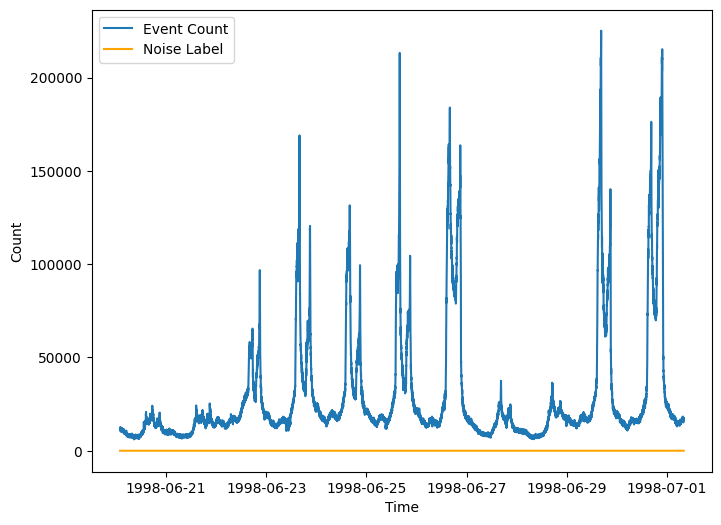

<ipython-input-73-c4b2c28d6160>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_noise_removed['event_time'] = pd.to_datetime(df_plot_noise_removed['event_time'])


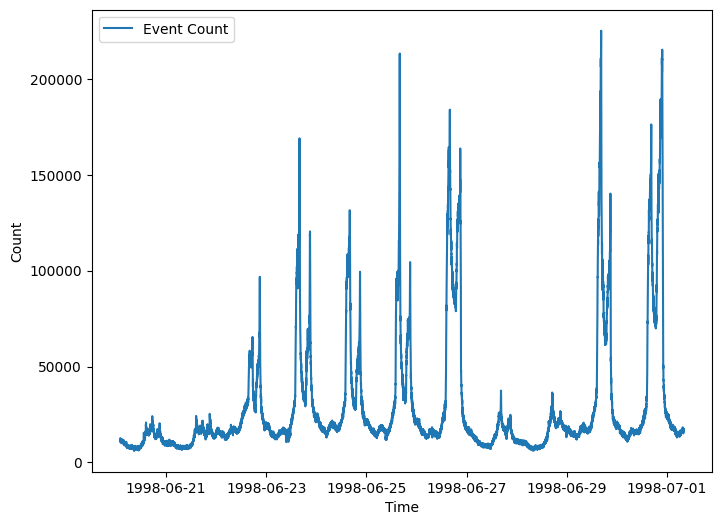

In [ ]:
# Define the start and end times for the plot
df_plot_noise_removed = df_noise_removed
df_plot_noise_removed['event_time'] = pd.to_datetime(df_plot_noise_removed['event_time'])
start_time = pd.to_datetime('1998-06-20 02:00:00')
end_time = pd.to_datetime('1998-07-01 8:00:00')
# Filter the data between the start and end times
df_filtered = df_plot_noise_removed.loc[(df_plot_noise_removed['event_time'] >= start_time) & (df_plot_noise_removed['event_time'] <= end_time)]
# Show the plot
plt.figure(figsize=(8, 6))
# Create the plot for both variables
plt.plot(df_filtered['event_time'], df_filtered['event_count'], label='Event Count')
plt.plot(df_filtered['event_time'], df_filtered['noise_label'], label='Noise Label',  color='orange')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.show()
# Define the start and end times for the plot
df_plot_noise_removed['event_time'] = pd.to_datetime(df_plot_noise_removed['event_time'])
start_time = pd.to_datetime('1998-06-20 02:00:00')
end_time = pd.to_datetime('1998-07-01 8:00:00')
# Filter the data between the start and end times
df_filtered = df_plot_noise_removed.loc[(df_plot_noise_removed['event_time'] >= start_time) & (df_plot_noise_removed['event_time'] <= end_time)]
# Show the plot
plt.figure(figsize=(8, 6))
# Create the plot for both variables
plt.plot(df_filtered['event_time'], df_filtered['event_count'], label='Event Count')
# plt.plot(df_filtered['event_time'], df_filtered['noise_label'], label='Noise Label',  color='orange')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.show()

In [ ]:
# Step 2: Load and preprocess the data
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_event_count = MinMaxScaler(feature_range=(0, 1))
df_noise_removed[['sum_bytes', 'num_match_event']] = scaler.fit_transform(df_noise_removed[['sum_bytes', 'num_match_event']])
df_noise_removed[['event_count']] = scaler_event_count.fit_transform(df_noise_removed[['event_count']])
# Drop any rows with missing values
data = df_noise_removed.dropna()
# Check for missing values in the dataframe
missing_values = df_noise_removed.isnull().sum()

# Print the number of missing values for each column
print(missing_values)
df_noise_removed.head()

event_count        0
sum_bytes          0
num_match_event    0
noise_label        0
dtype: int64


<ipython-input-20-06c574bd7d2e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noise_removed[['sum_bytes', 'num_match_event']] = scaler.fit_transform(df_noise_removed[['sum_bytes', 'num_match_event']])
<ipython-input-20-06c574bd7d2e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noise_removed[['event_count']] = scaler_event_count.fit_transform(df_noise_removed[['event_count']])


,event_count,sum_bytes,num_match_event,noise_label
0,0.000004,0.000036,0.0,0
1,0.000048,0.000122,0.0,0
2,0.000070,0.000129,0.0,0
3,0.000031,0.000219,0.0,0
4,0.000013,0.000074,0.0,0


In [ ]:
# drop column 'B'
df_noise_removed = df_noise_removed.drop('noise_label', axis=1)
df_noise_removed.head()

,event_count,sum_bytes,num_match_event
0,0.000004,0.000036,0.0
1,0.000048,0.000122,0.0
2,0.000070,0.000129,0.0
3,0.000031,0.000219,0.0
4,0.000013,0.000074,0.0


In [ ]:
# Step 3: Prepare the input and output data
# Create a function to create input and output data for the LSTM model
def create_input_output_data(scaled_data, sequence_length):
    X, Y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length])
        Y.append(scaled_data.iloc[i + sequence_length])
    return np.array(X), np.array(Y)

# Define the sequence length for the LSTM model
sequence_length = 10
# Create input and output data for the LSTM model
X, Y = create_input_output_data(df_noise_removed, sequence_length)

In [ ]:
df_noise_removed.shape, X.shape, Y.shape

((123653, 3), (123643, 10, 3), (123643, 3))

In [ ]:
X[0], Y[0]

(array([[4.35870390e-06, 3.62097597e-05, 0.00000000e+00],
        [4.79457429e-05, 1.21625327e-04, 0.00000000e+00],
        [6.97392623e-05, 1.28744023e-04, 0.00000000e+00],
        [3.05109273e-05, 2.18700449e-04, 0.00000000e+00],
        [1.30761117e-05, 7.38614103e-05, 0.00000000e+00],
        [8.71740779e-06, 7.24195194e-05, 0.00000000e+00],
        [1.30761117e-05, 1.08629279e-04, 0.00000000e+00],
        [1.74348156e-05, 1.44839039e-04, 0.00000000e+00],
        [2.17935195e-05, 1.46280930e-04, 0.00000000e+00],
        [3.92283351e-05, 2.55188340e-04, 0.00000000e+00]]),
 array([4.35870390e-06, 3.62097597e-05, 0.00000000e+00]))

In [ ]:
X[1], Y[1]

(array([[4.79457429e-05, 1.21625327e-04, 0.00000000e+00],
        [6.97392623e-05, 1.28744023e-04, 0.00000000e+00],
        [3.05109273e-05, 2.18700449e-04, 0.00000000e+00],
        [1.30761117e-05, 7.38614103e-05, 0.00000000e+00],
        [8.71740779e-06, 7.24195194e-05, 0.00000000e+00],
        [1.30761117e-05, 1.08629279e-04, 0.00000000e+00],
        [1.74348156e-05, 1.44839039e-04, 0.00000000e+00],
        [2.17935195e-05, 1.46280930e-04, 0.00000000e+00],
        [3.92283351e-05, 2.55188340e-04, 0.00000000e+00],
        [4.35870390e-06, 3.62097597e-05, 0.00000000e+00]]),
 array([2.17935195e-05, 1.44839039e-04, 0.00000000e+00]))

In [ ]:
X[-2], Y[-2]

(array([[0.00294213, 0.00543361, 0.        ],
        [0.00340415, 0.00323835, 0.        ],
        [0.00302494, 0.00674731, 0.        ],
        [0.00287239, 0.00368811, 0.        ],
        [0.00254984, 0.00311618, 0.        ],
        [0.0025542 , 0.00367726, 0.        ],
        [0.00290726, 0.0051291 , 0.        ],
        [0.00338671, 0.00383557, 0.        ],
        [0.00333005, 0.00411267, 0.        ],
        [0.0035785 , 0.00708328, 0.        ]]),
 array([0.00238421, 0.00554811, 0.        ]))

In [ ]:
X[-1], Y[-1]

(array([[0.00340415, 0.00323835, 0.        ],
        [0.00302494, 0.00674731, 0.        ],
        [0.00287239, 0.00368811, 0.        ],
        [0.00254984, 0.00311618, 0.        ],
        [0.0025542 , 0.00367726, 0.        ],
        [0.00290726, 0.0051291 , 0.        ],
        [0.00338671, 0.00383557, 0.        ],
        [0.00333005, 0.00411267, 0.        ],
        [0.0035785 , 0.00708328, 0.        ],
        [0.00238421, 0.00554811, 0.        ]]),
 array([0.00295956, 0.00680956, 0.        ]))

In [ ]:
df_noise_removed[-1:]

,event_count,sum_bytes,num_match_event
124463,0.00296,0.00681,0.0


In [ ]:
# Step 4: Split the data into training, validation and test sets
# Define the training, validation and testing set sizes
training_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.85)

# Split the data into training and testing sets
X_train, X_validation, X_test = X[:training_size], X[training_size:validation_size], X[validation_size:]
Y_train, Y_validation, Y_test = Y[:training_size], Y[training_size:validation_size], Y[validation_size:]

In [ ]:
X_train.shape, X_validation.shape, X_test.shape

((86550, 10, 3), (18546, 10, 3), (18547, 10, 3))

In [ ]:
Y_train.shape, Y_validation.shape, Y_test.shape

((86550, 3), (18546, 3), (18547, 3))

In [ ]:
Y_train

array([[4.35870390e-06, 3.62097597e-05, 0.00000000e+00],
       [2.17935195e-05, 1.44839039e-04, 0.00000000e+00],
       [8.71740779e-06, 7.24195194e-05, 0.00000000e+00],
       ...,
       [6.81317723e-01, 5.88440230e-01, 5.00000000e-01],
       [6.81130299e-01, 5.82905159e-01, 5.00000000e-01],
       [6.91944243e-01, 5.89725944e-01, 5.00000000e-01]])

In [ ]:
Y_train = Y_train[:,0].reshape(-1,1)
Y_validation = Y_validation[:,0].reshape(-1,1)
Y_test = Y_test[:,0].reshape(-1,1)

**This Bi-LSTM model has two LSTM layers:**
One bidirectional LSTM layer with 128 units and another LSTM layer with 64 units. There are also two dropout layers with a dropout rate of 0.2 between the LSTM layers to prevent overfitting. The model is compiled with an Adam optimizer and the mean squared error loss function. The early stopping callback is also defined to monitor the validation loss and stop training if the validation loss does not improve after 20 epochs.

In [ ]:
# Step 5: Define and train the LSTM model
# Define the LSTM model
model = Sequential()
## input_shape: If each input sample has 69 timesteps, where each timestep
## consists of 3 feature values, then the input shape would be (69, 3).
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(sequence_length, 3)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=128)))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the early stopping callback
# No se quan sat val_loss, neu 5 val_loss lien tiep ma khong giam => stop straining
# early_stop = EarlyStopping(monitor='val_loss', patience=5)
early_stop = EarlyStopping(monitor='val_loss', mode='min',verbose=1, restore_best_weights=True, patience=20)
# Train the Bi-LSTM model
X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('float32')
model.fit(X_train, Y_train, epochs=100, callbacks=[early_stop], verbose=1, validation_data=(X_validation,Y_validation), batch_size=32)

Epoch 1/100
2705/2705 [==============================] - 272s 98ms/step - loss: 1.3622e-04 - val_loss: 5.5721e-05
Epoch 2/100
2705/2705 [==============================] - 253s 94ms/step - loss: 6.8846e-05 - val_loss: 2.6663e-05
Epoch 3/100
2705/2705 [==============================] - 252s 93ms/step - loss: 6.2976e-05 - val_loss: 6.6468e-05
Epoch 4/100
2705/2705 [==============================] - 245s 91ms/step - loss: 5.7342e-05 - val_loss: 3.9110e-05
Epoch 5/100
2705/2705 [==============================] - 244s 90ms/step - loss: 5.7957e-05 - val_loss: 9.1220e-05
Epoch 6/100
2705/2705 [==============================] - 249s 92ms/step - loss: 5.5998e-05 - val_loss: 2.6820e-05
Epoch 7/100
2705/2705 [==============================] - 241s 89ms/step - loss: 5.2451e-05 - val_loss: 2.5233e-05
Epoch 8/100
2705/2705 [==============================] - 247s 91ms/step - loss: 5.1892e-05 - val_loss: 2.3929e-05
Epoch 9/100
2705/2705 [==============================] - 251s 93ms/step - loss: 5.0908e-

In [ ]:
X_validation[0]

array([[0.67385562, 0.55574061, 0.5       ],
       [0.67228649, 0.5650388 , 0.5       ],
       [0.68172744, 0.57848805, 0.5       ],
       [0.68553259, 0.58395586, 0.5       ],
       [0.68976489, 0.58638398, 0.5       ],
       [0.68036753, 0.58935977, 0.5       ],
       [0.6800537 , 0.5847675 , 0.5       ],
       [0.68131772, 0.58844023, 0.5       ],
       [0.6811303 , 0.58290516, 0.5       ],
       [0.69194424, 0.58972594, 0.5       ]])

In [ ]:
predict_validation = model.predict(X_validation)
predict_validation

580/580 [==============================] - 16s 25ms/step


array([[0.69036347],
       [0.7095794 ],
       [0.71207374],
       ...,
       [0.06825612],
       [0.06754348],
       [0.06633388]], dtype=float32)

In [ ]:
predict_test = model.predict(X_test)
predict_test

580/580 [==============================] - 14s 24ms/step


array([[0.06394851],
       [0.06483085],
       [0.06540941],
       ...,
       [0.00333645],
       [0.00347645],
       [0.00281407]], dtype=float32)

In [ ]:
df.max()

event_count           229426
sum_bytes          683130742
num_match_event        40000
noise_label           250000
dtype: int64

In [ ]:
predict_validation_inverse = scaler_event_count.inverse_transform(predict_validation)
Y_validation_inverse = scaler_event_count.inverse_transform(Y_validation)
Y_validation_inverse

array([[162074.],
       [161783.],
       [164356.],
       ...,
       [ 15493.],
       [ 15075.],
       [ 14246.]])

In [ ]:
predict_test_inverse = scaler_event_count.inverse_transform(predict_test)
Y_test_inverse = scaler_event_count.inverse_transform(Y_test)
Y_test_inverse

array([[14688.],
       [14914.],
       [15516.],
       ...,
       [  821.],
       [  547.],
       [  679.]])

In [ ]:
predict_validation_inverse.shape, predict_test_inverse.shape
predict_validation_inverse

NameError: ignored

In [ ]:
plot_validation = Y_validation_inverse
plot_validation = pd.DataFrame(plot_validation)
plot_validation.columns = ['real_validation']
plot_validation.head()
plot_validation['predict_validation'] = predict_validation_inverse
plot_validation.head()
# plot_validation.columns = ['real_validation', 'predict_validation']

NameError: ignored

In [ ]:
plot_test = Y_test_inverse
plot_test = pd.DataFrame(plot_test)
plot_test.columns = ['real_test']
plot_test['predict_test'] = predict_test_inverse
plot_test.columns = ['real_test', 'predict_test']
plot_test.head()

,real_test,predict_test
0,14688.0,14671.451172
1,14914.0,14873.881836
2,15516.0,15006.618164
3,14392.0,15366.103516
4,15417.0,14727.772461


<Axes: >

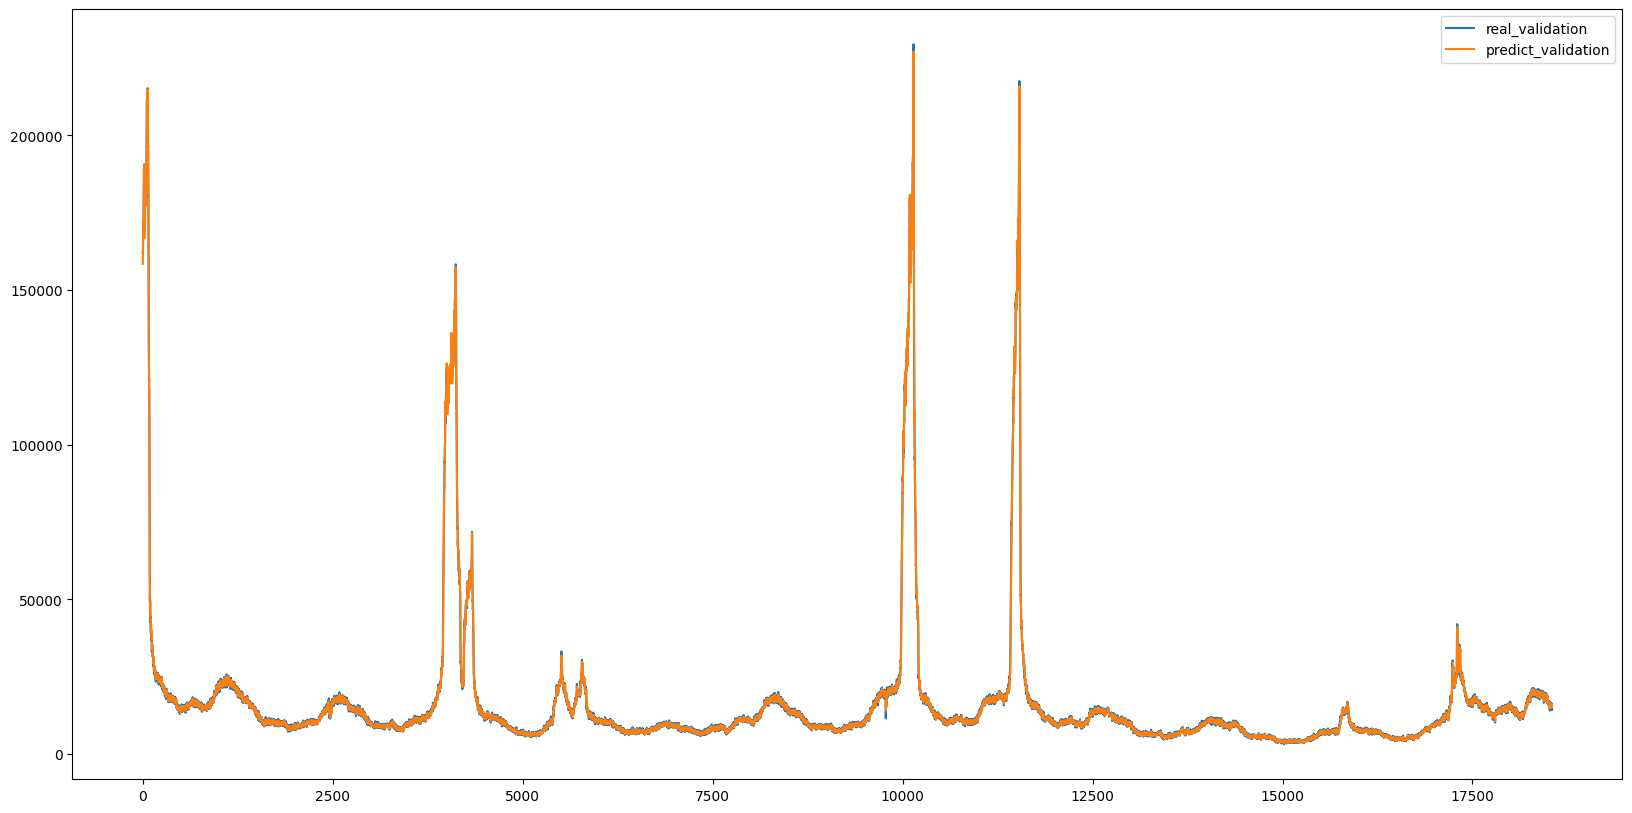

In [ ]:
plot_validation.plot(figsize=(20,10))

<Axes: >

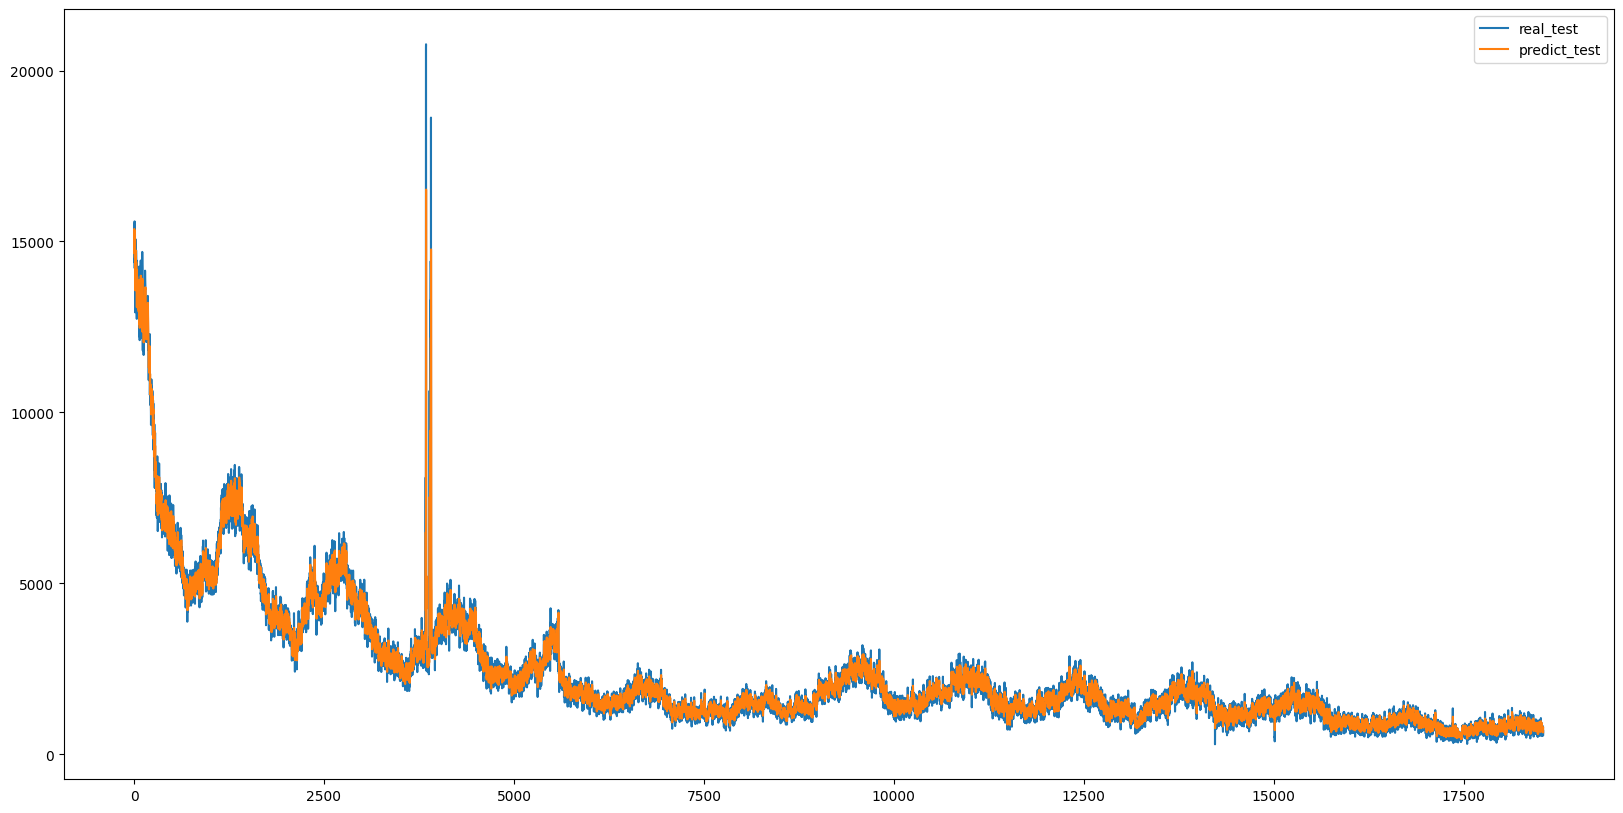

In [ ]:
plot_test.plot(figsize=(20,10))

In [ ]:
a = plot_test

In [ ]:
a.head()

,real_test,predict_test
0,14688.0,14671.451172
1,14914.0,14873.881836
2,15516.0,15006.618164
3,14392.0,15366.103516
4,15417.0,14727.772461


In [ ]:
b = (plot_test['predict_test'] - a['real_test'])/a['real_test']

In [ ]:
b.head()

0   -0.001127
1   -0.002690
2   -0.032829
3    0.067684
4   -0.044706
dtype: float64

In [ ]:
b.max()

5.412345175417314

In [ ]:
b_minidx = b.idxmin()
b_minidx

3841

In [ ]:
plot_test.loc[3900]

real_test       13274.000000
predict_test     3691.354492
Name: 3900, dtype: float64

In [ ]:
b.max()

5.412345175417314

<Axes: >

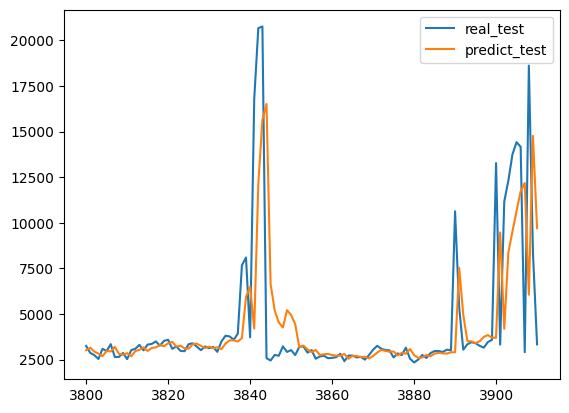

In [ ]:
q=plot_test.loc[3800:3910]
q.plot()

In [ ]:
b1=b.loc[0:5700]
b2=b.loc[5715:]
b1.max(),b1.min()
b2.max(),b2.min()

(3.342904256879266, -0.49186104121372065)

In [ ]:
b[b<0].shape

(8275,)

In [ ]:
b.shape

(18547,)

In [ ]:
# Save the scaler for event count to a file
# dump(scaler_event_count, '/content/drive/MyDrive/thesis/model-out/scaler-eventcount-bi-lstm.joblib')

['/content/drive/MyDrive/thesis/model-out/scaler-eventcount-bi-lstm.joblib']

In [ ]:
# dump(scaler, '/content/drive/MyDrive/thesis/model-out/scaler-bi-lstm.joblib')

['/content/drive/MyDrive/thesis/model-out/scaler-bi-lstm.joblib']

In [ ]:
# model.save("/content/drive/MyDrive/thesis/model-out/bi-lstm-model.h5")